# Solution to Exercise 7: Active ion channels and a small network

Below: Code given in the original assignment.

In [1]:
%matplotlib inline
!nrnivmodl
from neuron import h, load_mechanisms
from numpy import trapz
import matplotlib.cm as cm
import matplotlib.pyplot as plt

/mnt/user/shared/FYS388_test2/comp_neuro_course/Exercises/Exercise07
Mod files: "./Cad.mod" "./HH_traub.mod" "./Ican.mod" "./iahp.mod" "./iar.mod" "./ical.mod" "./it2.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread /srv/main-spack-instance-2402/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/readline-8.2-fyomclrl5v4af2xdqr3lvubsauokgjtj/lib/libreadline.so -Wl,-rpath,/srv/main-spack-instance-2402/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/readline-8.2-fyomclrl5v4af2xdqr3lvubsauokgjtj/lib /srv/main-spack-instance-2402/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/ncurses-6.4-kmcqrtvkqajlqndesa26t7e7qz7jy3iw/lib/libcurses.so -Wl,-rpath,/srv/main-spack-instance-2402/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/ncurses-6.4-kmcqrtvkqajlqndesa26t7e7qz7jy3iw/lib /srv/main-spack-instance-2402/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/ncurses-6.4-kmcqrtvkqajlqndesa26t7e7qz7jy

In [2]:
class Mymodel(object): # Template for defining a cell model
    # Creates neuron model
    def __init__(self,gna,gkdr,gahp,gcat,gcal,ghbar):
        self.create_cell()
        self.define_geometry()
        self.define_biophysics(gna,gkdr,gahp,gcat,gcal,ghbar)
        h.celsius = 36
    def create_cell(self):
        self.soma = h.Section(name='soma', cell=self)
    def define_geometry(self):
        self.soma.L = self.soma.diam = 20     # microns
        h.define_shape() # Translate into 3D points.
    def define_biophysics(self,
                 gna = 0.01, 
                 gkdr = 0.01, 
                 gahp = 5e-5, 
                 gcat = 2e-4, 
                 gcal = 0.0009, 
                 hhbar = 0.00005):
        # Passive properties
        rall = 200 # axial resistance
        cap = 1.1 # membrane capacitance
        Rm = 45000.0 # membrane resistance
        Epas = -80 
        nash = - 52.6
        kdrsh = -51.2
        catau = 50
        
        self.soma.insert('pas')
        self.soma.e_pas = Epas
        self.soma.g_pas = 1/Rm
        self.soma.cm = cap
        self.soma.insert("iar")
        self.soma.insert("hh2")
        self.soma.insert("Cad")
        self.soma.insert("it2")
        self.soma.insert("ical")
        self.soma.insert("iahp")
        self.soma.ena = 50 # Reversal potential for sodium
        self.soma.ek = -90 # Reversal potential for potassium 
        self.soma.gnabar_hh2 = gna
        self.soma.gkbar_hh2 = gkdr
        self.soma.gcabar_it2 = gcat
        self.soma.vtraubNa_hh2 = nash 
        self.soma.vtraubK_hh2 = kdrsh
        self.soma.pcabar_ical = gcal
        self.soma.gkbar_iahp = gahp
        self.soma.ghbar_iar = ghbar

In [3]:
# Functions that controls what to record and how to plot (t and Vm and Ca++)
def set_recording_vectors(cell):
    soma_v_vec = h.Vector()   # Membrane potential vector at soma
    soma_ca_vec = h.Vector()   # Membrane potential vector at soma
    t_vec = h.Vector()        # Time stamp vector
    soma_v_vec.record(cell.soma(0.5)._ref_v)
    soma_ca_vec.record(cell.soma(0.5)._ref_Cai)
    t_vec.record(h._ref_t)
    return soma_v_vec, soma_ca_vec, t_vec

# Function that runs simulation
def simulate(tstop=2000):
    h.tstop = tstop
    h.run()

# Function that plots output
def show_output(soma_v_vec,soma_ca_vec, t_vec, new_fig=True):
    if new_fig:
        plt.figure(figsize=(10,4)) # Default figsize is (8,6)
    vax = plt.subplot(121)
    plt.title('Voltage')
    plt.xlabel('time (ms)')
    plt.ylabel('mV')
    cax = plt.subplot(122)
    plt.xlabel('time (ms)')
    plt.ylabel('nM')
    plt.title('Calcium')
    vax.plot(t_vec, soma_v_vec, color='black')
    cax.plot(t_vec, 1e6*soma_ca_vec, color='black')
    plt.subplots_adjust(wspace = 0.3) 

## Solution to Exercise 7.1 a)
__a)__ To "see" the resting potential, we set the stimulus amplitude to zero (or rather, do not insert a stimulus) and read off what potential the neuron stabilizes on. To explore how various conductances affect the resting potential, we may one-by-one multiply the initial conductances by a constant factor (let's say 2) and see how this affects the resting potential. Most conductances are (almost entirely) inactive during resting condictions, since they activate at higher voltages. Changing them will thus not have any significant effect on the resting potential. The main exception in this case is the T-type calcium channel (parameter $gcat$), and to a smaller degree also the L-type calcium channel (parameter $gcal$). When $gcat$ was multiplied by a factor 2, the resting potential was increased by 2 mV. This indictates that the T-type calcium channel is quite open also during rest, and may be important for the voltage dynamics of the cell when it is below firing threshold. (If you multiply it by a factor 5 you can even make a spontaneously active cell, i.e., one that fires bursts of action potentials even if it receives no output. Try if you want to). 

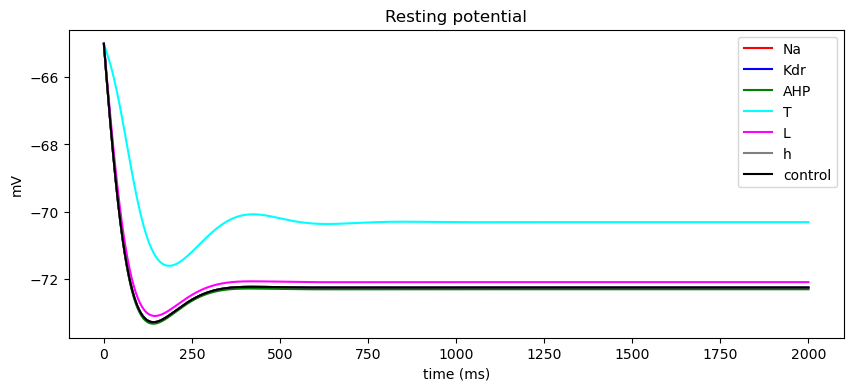

In [4]:
# Default parameters
gna =  0.01 # S/cm2
gkdr = 0.01
gahp = 5e-5
gcat= 2e-4
gcal=0.0009
ghbar=0.00005

fac = 2

# Create model with the above parameters
cell0 = Mymodel(gna,gkdr,gahp,gcat,gcal,ghbar)

# Vary one by one parameter by multiplying it by a factor 2
cellNa = Mymodel(gna*fac,gkdr,gahp,gcat,gcal,ghbar)
cellK = Mymodel(gna,gkdr*fac,gahp,gcat,gcal,ghbar)
cellAHP = Mymodel(gna,gkdr,gahp*fac,gcat,gcal,ghbar)
cellT = Mymodel(gna,gkdr,gahp,gcat*fac,gcal,ghbar)
cellL = Mymodel(gna,gkdr,gahp,gcat,gcal*fac,ghbar)
cellh = Mymodel(gna,gkdr,gahp,gcat,gcal,ghbar*fac)
soma_v_vec0, soma_ca_vec0, t_vec0 = set_recording_vectors(cell0)
soma_v_vecNa, soma_ca_vecNa, t_vecNa = set_recording_vectors(cellNa)
soma_v_vecK, soma_ca_vecK, t_vecK = set_recording_vectors(cellK)
soma_v_vecAHP, soma_ca_vecAHP, t_vecAHP = set_recording_vectors(cellAHP)
soma_v_vecT, soma_ca_vecT, t_vecT = set_recording_vectors(cellT)
soma_v_vecL, soma_ca_vecL, t_vecL = set_recording_vectors(cellL)
soma_v_vech, soma_ca_vech, t_vech = set_recording_vectors(cellh)

h.load_file('stdrun.hoc')
simulate()

plt.figure(figsize=(10,4)) # Default figsize is (8,6)
plt.title('Resting potential')
plt.xlabel('time (ms)')
plt.ylabel('mV')
pNa = plt.plot(t_vecNa, soma_v_vecNa, color='red')
pK = plt.plot(t_vecK, soma_v_vecK, color='blue')
pAHP = plt.plot(t_vecAHP, soma_v_vecAHP, color='green')
pT = plt.plot(t_vecT, soma_v_vecT, color='cyan')
pL = plt.plot(t_vecL, soma_v_vecL, color='magenta')
ph = plt.plot(t_vech, soma_v_vech, color='grey')
p0 = plt.plot(t_vec0, soma_v_vec0, color='black')
plt.legend(pNa + pK + pAHP + pT + pL + ph + p0, ['Na', 'Kdr', 'AHP', 'T', 'L', 'h', 'control'])

## Solution to Exercise 7.1 b-i)
The code below qualitatively the firing patterns in Figure 1 of the exercise assignment.

__b)__ The initial burst seen here (Fig. 2A below) is mainly due to the T-type calcium channel. If you turn it off, the burst disappears (see also __e)__ below), and it fires regularly because of the Na+ and K+ channels (as in the good-old Hodgkin-Huxley model). The explanation for the burst is that the T-type (low-voltage-activated) calcium channel is most active in a time window after the neuron has been stepped from a low to a high voltage. This creates a bump in the potential immediately after stimulus onset, and because of this depolarization, the neuron fires faster. Since the bump is generated by a calcium channel, it is often called a calcium spike. You can see the bump in isolation if you turn off the Na+ channel (set $gna=0$). 

__c)__ During a burst, large amounts of calcium enters the cell (you can see this in Figure 2 of the exercise assignment). This triggers the calcium-activated K+ channel ($I_{AHP}$), which hyperpolarizes the cell after the burst. If the burst (via $gcat$) and the afterhyperpolarization (via $gahp$) are strong enough, the neuron can go through a periodical cycle of burst-afterhyperpolarization-burst-afterhyperpolarization, as in Fig. 2B below. The strong and enduring aftehyperpolarization is needed to prepare the neuron for a new burst-triggering "jump" from high to low potentials (as in __b)__).

__d)__ If $gahp$ becomes too strong, it can prevent the bursts from occuring (essentialy, it the disalows the neuron to do a powerful enough rebound from the hyperpolarization (see __h)__ below)). The neuron may "try" to burst periodically, but fails to cross the AP-firing threshold because of a remaining component of $I_{AHP}$. These burst-attempts can be seen as periodic sub-threshold oscillations in the membrane potential, known as calcium oscillations (see Fig. 2C below).

__e)__ As already discussed, the neuron fires regularly if $gcat$ is set to zero (see Fig. 2D below).

__f)__ Two K+ channels are present in the model. Under the most common circumstanses, it is the standard direct rectifying $I_{Kdr}$ (known from the Hodgkin-Huxley model) that mediates the downstroke of the action potential. If $gkdr$ is increased, we get a more pronounced hyperpolarization immediately after an AP. $I_{Kdr}$ is thus responsible for the sharp afterhyperpolarization seen in Fig. 2E below. $I_{AHP}$ is a slower and more complex mechanism, since it is triggered by calcium that enters the cell during the AP (i.e., its activation level will depend on how much we have of the calcium channels (conductances $gcat$ and $gcal$). However, if we boost hyperpolarization by increasing $gahp$ instead of $gkdr$, we generally obtain smoother and more enduring afterhyperpolarization between APs (Fig. 2F below).

__g)__ The initial "sag" in the response to a hyperpolarizing step-pulse is mediated by $I_h$. This is easy to see, because the sag is visible if all conductances except $gh$ is set to zero (Fig. 2G below). As its name indicates, $I_h$ is hyperpolarization-activated. It basically does nothing unless the cell is hyperpolarized. Upon hyperpolarization, $I_h$ activates (slowly) to bring the neuron up to a slightly little less hyperpolarized potential. When the neuron is released from hyperpolarization, $I_h$ is still open, and this explains the little overshoot in the membrane potential during its recovery from hyperpolarization.

__h)__  Could we, by increasing $gh$ make the overshoot that we saw in Fig.2G so large that it pushes the neuron above firing threshold and into a burst? The answer is no. It needs some help also from the good old bursting mechanism $I_T$. Jointly, sufficiently large values for $gh$ and $gt$ can make the cell do a rebound burst when released from hyperpolarization (Fig. 2H below). Of course it will also need its Na+ and K+ channels in addition to fire APs.

Text(0.5, 0, 'time (ms)')

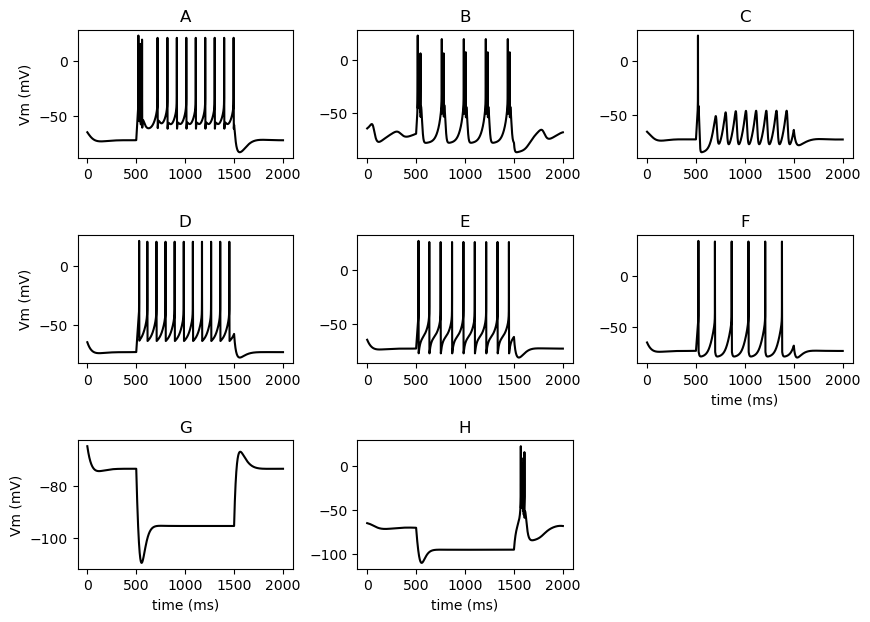

In [6]:
h.load_file('stdrun.hoc')

cell1 = Mymodel(0.01,0.01,5e-5,2e-4,0.0009,0.00005)
cell2 = Mymodel(0.01,0.01,3*5e-5,3*2e-4,0.0009,0.00005)
cell3 = Mymodel(0.01,0.01,6*5e-5,1.5*2e-4,0.0009,0.00005)
cell4 = Mymodel(0.01,0.01,5e-5,0*2e-4,0.0009,0.00005)
cell5 = Mymodel(0.02,2.5*0.02,5e-5,0*2e-4,3*0.0009,0.00005)
cell6 = Mymodel(0.02,0.02,3*5e-5,0*2e-4,3*0.0009,0.00005)
cell7 = Mymodel(0*0.01,0*0.01,0*5e-5,0*2e-4,0*0.0009,0.00005)
cell8 = Mymodel(0.01,0.01,5e-5,2*2e-4,0.0009,0.00005)

stim1 = h.IClamp(cell1.soma(0.5))
stim1.delay = 500
stim1.dur = 1000
stim1.amp = 0.02
stim2 = h.IClamp(cell2.soma(0.5))
stim2.delay = 500
stim2.dur = 1000
stim2.amp = 0.02
stim3 = h.IClamp(cell3.soma(0.5))
stim3.delay = 500
stim3.dur = 1000
stim3.amp = 0.02
stim4 = h.IClamp(cell4.soma(0.5))
stim4.delay = 500
stim4.dur = 1000
stim4.amp = 0.02
stim5 = h.IClamp(cell5.soma(0.5))
stim5.delay = 500
stim5.dur = 1000
stim5.amp = 0.02
stim6 = h.IClamp(cell6.soma(0.5))
stim6.delay = 500
stim6.dur = 1000
stim6.amp = 0.02
stim7 = h.IClamp(cell7.soma(0.5))
stim7.delay = 500
stim7.dur = 1000
stim7.amp = -0.02
stim8 = h.IClamp(cell8.soma(0.5))
stim8.delay = 500
stim8.dur = 1000
stim8.amp = -0.02

v_vec1, soma_ca_vec1, t_vec1 = set_recording_vectors(cell1)
v_vec2, soma_ca_vec2, t_vec2 = set_recording_vectors(cell2)
v_vec3, soma_ca_vec3, t_vec3 = set_recording_vectors(cell3)
v_vec4, soma_ca_vec4, t_vec4 = set_recording_vectors(cell4)
v_vec5, soma_ca_vec5, t_vec5 = set_recording_vectors(cell5)
v_vec6, soma_ca_vec6, t_vec6 = set_recording_vectors(cell6)
v_vec7, soma_ca_vec7, t_vec7 = set_recording_vectors(cell7)
v_vec8, soma_ca_vec8, t_vec8 = set_recording_vectors(cell8)

simulate()

plt.figure(figsize=(10,7)) # Default figsize is (8,6)
plt.subplots_adjust(wspace = 0.3, hspace = 0.6)
ax1 = plt.subplot(331)
ax1.plot(t_vec1, v_vec1, color='black')
plt.title('A')
plt.ylabel('Vm (mV)')
ax2 = plt.subplot(332)
ax2.plot(t_vec2, v_vec2, color='black')
plt.title('B')
ax3 = plt.subplot(333)
ax3.plot(t_vec3, v_vec3, color='black')
plt.title('C')
ax4 = plt.subplot(334)
ax4.plot(t_vec4, v_vec4, color='black')
plt.title('D')
plt.ylabel('Vm (mV)')
ax5 = plt.subplot(335)
ax5.plot(t_vec5, v_vec5, color='black')
plt.title('E')
ax6 = plt.subplot(336)
ax6.plot(t_vec6, v_vec6, color='black')
plt.title('F')
plt.xlabel('time (ms)')
ax7 = plt.subplot(337)
ax7.plot(t_vec7, v_vec7, color='black')
plt.title('G')
plt.ylabel('Vm (mV)')
plt.xlabel('time (ms)')
ax8 = plt.subplot(338)
ax8.plot(t_vec8, v_vec8, color='black')
plt.title('H')
plt.xlabel('time (ms)')

## Solution to Exercise 7.2 a-c: A small ring-network of spiking neurons
There are of course a number of ways to solve this task, and the assignment was not very specific. The main point was to be able to program a small network and get some feeling for the network dynamics. 

__a)__ Example code for constructing a simple ring-network is found below. Only one example is given, where the first neuron is started by a synapse with weight 0.04, and the network weight $w=0.02$. You should easilly be able to manipulate those two parameters to reproduce the answers to all questions (__b)__-__d)__) below. 

__b)__ In the example code, an external stimulus of strength "ncstim.weight[0] = 0.04" was used to trigger spiking in the first neuron. A property with the neuron model that we use here is that it has a tendency to burst. That is, if we give it an input it is likely to respond either by zero APs (because the input was too weak) or by several (because of the bursting tendency). The transition from zero to several spikes is rather sharp, and only for a quite narrow band of input strengths, the neuron responds by only a single AP. Let us for now stick with the weight of 0.04, and kick-start the network activiy with a burst in the first neuron.

__c)__ As expected, for low values the network weight ($0<w<0.011$), the activity of the first neuron is not suficcient to trigger spiking in its neighbour. For slightly higher network weights ($0.012<w<0.015$), the first neuron triggers a spike in its neighbour, but that one spike is not sufficient to trigger spiking in the next neuron in the chain. For higher weights ($0.016<w<0.09$) the first neuron makes the second neuron burst, and the second makes the third neuron burst, so that the activity propates through the entire network, and all neurons get to fire a burst. Interestingly, it does not go a second round! If the weight is increased further, a single AP is sufficient for a neuron to trigger its neighbour, and then the activity can go on forever. 

__d)__ The reason it is possible that the activity dies out after one cycle, is that the after one round, the first neuron is in a different state then it was initially (it has recently bursted and is not at the resting potential), and it is then less ready to fire a new burst. We may also note that if the network weight is set to an extremely high value (e.g. $w=10$), the network activity again dies out after one cycle. My (hand-waving) explanation to this is that for such high coupling, the cells drive eachother to a sparkling burst almost simultaneously, which means that they also simultaneously enter a period of heavy afterhyperpolarization, where all cells are inactive at the same time, and nobody is awake to keep up the network activity. 

__e)__ If you remove the bursting mechanism (setting $gcat$ to zero) you should probably get a much simpler scenario with only two options: (1) $w$ is too weak for activity to propagate through the network, or (2) $w$ is strong enough, and network activity goes on forever.

In [7]:
from neuron import h
import matplotlib.pyplot as plt

def set_recording_vectors(cell):
    """Set soma, dendrite, and time recording vectors on the cell.

    :param cell: Cell to record from.
    :return: the soma, dendrite, and time vectors as a tuple.
    """
    soma_v_vec = h.Vector()   # Membrane potential vector at soma
    t_vec = h.Vector()        # Time stamp vector
    soma_v_vec.record(cell.soma(0.5)._ref_v)
    t_vec.record(h._ref_t)
    return soma_v_vec, t_vec

def simulate(tstop=2000):
    """Initialize and run a simulation.

    :param tstop: Duration of the simulation.
    """
    h.tstop = tstop
    h.run()

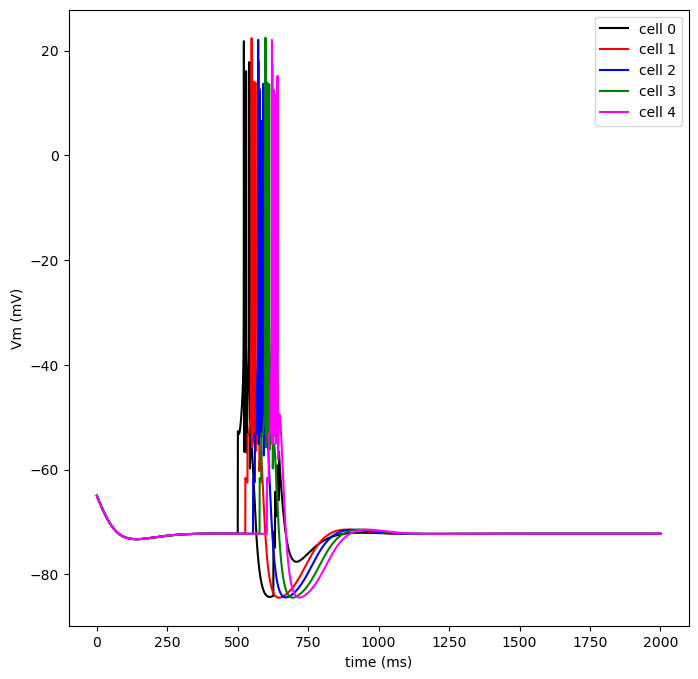

In [8]:
# https://neuron.yale.edu/neuron/docs/ball-and-stick-model-part-2
# Channel densities
gna =  0.01 # S/cm2
gkdr = 0.01
gahp = 5e-5
gcat= 2e-4
gcal=0.0009
ghbar=0.00005

cells = []
N = 5
r = 50 # Radius of cell locations from origin (0,0,0) in microns
for i in range(N):
    nwcell = Mymodel(gna,gkdr,gahp,gcat,gcal,ghbar)
    # Then reposition
    cells.append(nwcell)
    
stim = h.NetStim() # Make a new stimulator

syn_ = h.ExpSyn(cells[0].soma(0.5))
stim.number = 1
stim.start = 500
ncstim = h.NetCon(stim, syn_)
ncstim.delay = 0
ncstim.weight[0] = 0.04 # NetCon weight is a vector.

nclist = []
syns = []
for i in range(N):
    src = cells[i]
    tgt = cells[(i + 1) % N]
    syn = h.ExpSyn(tgt.soma(0.5))
    syns.append(syn)
    nc = h.NetCon(src.soma(0.5)._ref_v, syn, sec=src.soma)
    nc.weight[0] = 0.02
    nc.delay = 5
    nclist.append(nc)
    
soma_v_vec0, t_vec0 = set_recording_vectors(cells[0])
soma_v_vec1, t_vec1 = set_recording_vectors(cells[1])
soma_v_vec2, t_vec2 = set_recording_vectors(cells[2])
soma_v_vec3, t_vec3 = set_recording_vectors(cells[3])
soma_v_vec4, t_vec4 = set_recording_vectors(cells[4])

simulate()
plt.figure(figsize=(8,8)) # Default figsize is (8,6)
p1 = plt.plot(t_vec0, soma_v_vec0, color='black')
p2 = plt.plot(t_vec1, soma_v_vec1, color='red')
p3 = plt.plot(t_vec2, soma_v_vec2, color='blue')
p4 = plt.plot(t_vec3, soma_v_vec3, color='green')
p5 = plt.plot(t_vec4, soma_v_vec4, color='magenta')
plt.ylabel('Vm (mV)')
plt.xlabel('time (ms)')
plt.legend(p1 + p2 + p3 + p4 + p5, ['cell 0', 'cell 1', 'cell 2', 'cell 3', 'cell 4'])
